<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/FFEedgesNumbaDask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [8]:
%cd /content/drive/My Drive/Colab Notebooks/01_Repository/FFE
# ! git pull

/content/drive/My Drive/Colab Notebooks/01_Repository/FFE


importing 
---



In [2]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes

CPU times: user 736 ms, sys: 147 ms, total: 883 ms
Wall time: 4min 54s


In [46]:
%%time
import datetime
import glob
from math import sqrt
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from scipy.spatial import distance
from shapely.geometry import box
from shapely.geometry import shape
from shapely.geometry import Point
import networkx as nx
from sys import getsizeof
from numba import jit
import dask.dataframe as dd
import dask.array as da
import dask
from dask.distributed import Client
from dask.diagnostics import ProgressBar
%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

CPU times: user 1.35 ms, sys: 0 ns, total: 1.35 ms
Wall time: 1.35 ms


In [9]:
# %%capture
client = Client(processes=False)
client

/usr/local/lib/python3.6/dist-packages/distributed/bokeh/core.py:57: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 99] Cannot assign requested address
  warnings.warn('\n' + msg)
/usr/local/lib/python3.6/dist-packages/distributed/deploy/local.py:197: UserWarning: 
Could not launch service 'bokeh' on port 8787. Got the following message:

[Errno 99] Cannot assign requested address
  self.scheduler.start(scheduler_address)


Client Scheduler: inproc://172.28.0.2/141/13,Cluster Workers: 1 Cores: 4 Memory: 27.39 GB


runs
---



In [11]:
path = './data'
pathShapefile = './data/shapefile'
path_output = './output'

In [ ]:
os.listdir(pathShapefile)

**Load GIS data**



---






In [15]:
def load_data(file_name, minx, miny, maxx, maxy):
    # crop data
    bbox = box(minx, miny, maxx, maxy)
    # building point dataset
    gdf_buildings = gpd.read_file(os.path.join(pathShapefile, file_name), bbox=bbox)
    gdf_buildings['X'] = gdf_buildings.geometry.centroid.x
    gdf_buildings['Y'] = gdf_buildings.geometry.centroid.y

    # print(gdf_buildings.dtypes)
    max_extent = gdf_buildings.total_bounds
    data_size = getsizeof(gdf_buildings) /(1024.0**3)
    print("Shapefile extent : {}".format(max_extent))
    print("Asset loaded : {}".format(len(gdf_buildings)))
    # print("Data size:{} GB'".format(data_size))
    # gdf_buildings.IgnProb_bl = 0.02
    # xmin,ymin,xmax,ymax = gdf_buildings.total_bounds

    # # Precision of float32 is sufficient for lat and lon
    # float_columns = ['SHAPE_Leng','SHAPE_Area',
    #                 'IgnProb_bl','RandProb']
    # gdf_buildings[float_columns] = gdf_buildings[float_columns].astype('float32')
    # int_columns = ['TARGET_FID','Combustibl',
    #                 'AU2013Num','RandProb']
    # gdf_buildings[int_columns] = gdf_buildings[int_columns].astype('int32')
    # data_size = getsizeof(gdf_buildings)/(1024.0**3)
    # print("resized Data size:{} GB'".format(data_size))

    return gdf_buildings


def clean_up_file(prefix, path_path):
    files = glob.glob(os.path.join(path_path, prefix))
    for file in files:
        print(file)
        os.remove(file)

In [ ]:
# clean_up_file("*", path_split)

Shapefile extent : [1743666.2636 5421069.8387 1755072.1121 5443033.4851]
Asset loaded : 73735
CPU times: user 33.5 s, sys: 3.09 s, total: 36.6 s
Wall time: 33.5 s


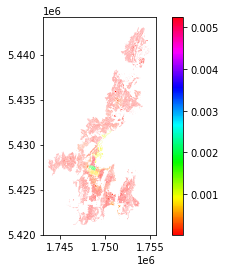

In [20]:
%%time
# load data
# gdf = load_data("buildings_raw.shp", 1748570, 5425500, 1749500, 5427600) # small
# gdf = load_data("buildings_raw.shp", 1745000, 5424148, 1750000, 5430000) # larger
gdf = load_data("WellWHV_Buildings.shp", 1740508, 5420049, 1755776, 5443033) # whole
gdf.plot(column='IgnProbBld', cmap='hsv', legend=True)

In [23]:
gdf.insert(0, 'FID', range(0, len(gdf)))

In [24]:
gdf.head()

,FID,Replacemen,Combustibl,FloorArea,BLDG_ID,SA2_ID,NightOccup,IgnProbBld,geometry,X,Y
0,0,271128.0,1,156.0,1,67,3.0,0.000040,"POLYGON ((1748253.040 5422598.875, 1748260.639...",1.748256e+06,5.422592e+06
1,1,66044.0,1,38.0,2,75,1.0,0.000024,"POLYGON ((1752652.050 5423208.879, 1752658.230...",1.752656e+06,5.423206e+06
2,2,56944.0,1,21.0,3,23,0.0,0.000101,"POLYGON ((1750820.799 5434554.465, 1750819.180...",1.750818e+06,5.434553e+06
3,3,307626.0,1,177.0,4,38,3.0,0.000102,"POLYGON ((1750052.705 5432505.105, 1750056.199...",1.750061e+06,5.432502e+06
4,4,342386.0,1,197.0,5,60,3.0,0.000081,"POLYGON ((1748074.536 5424848.405, 1748075.076...",1.748083e+06,5.424849e+06


**List of Functions**



---





In [52]:
%%time
# create edge list from id
fid = gdf.FID.values
x = gdf.X.values
y = gdf.Y.values
combustible = gdf.Combustibl.values

@jit(nopython=True)
def square(x):
    return x ** 2

@jit(nopython=True)
def distance(x, y):
    return np.sqrt(square(x) + square(y))

@jit(nopython=True)
def bearing(x, y):
    azimuth = np.degrees(np.arctan2(x, y))
    return (azimuth + 360) % 360

@jit(nopython=True)
def edge_list(fid, x, y, combustible):
  list_s = []
  list_t = []
  list_distance = []
  list_bearing = []
  for idx_s, s in enumerate(fid):
    if combustible[idx_s] != 0:
        for idx_t, t in enumerate(fid):
          if combustible[idx_t] != 0:

            Vx = (x[idx_s] - x[idx_t])
            Vy = (y[idx_s] - y[idx_t])

            dist = distance(Vx, Vy)
            bear = bearing(Vx, Vy)

            if dist < 100 and dist != 0:
              
              list_s.append(s)
              list_t.append(t)
              list_distance.append(dist)
              list_bearing.append(bear)

  return list_s, list_t, list_distance, list_bearing

CPU times: user 45.2 ms, sys: 16.4 ms, total: 61.6 ms
Wall time: 59.8 ms


In [33]:
def to_dask_df(source, target, distance, bearing):
  list_of_lists = [source, target, distance, bearing]
  list_of_arrays = []
  for l in list_of_lists:
    a = da.array(l)
    list_of_arrays.append(a)

  # generate dask dataframe
  ddf = dd.concat([dd.from_dask_array(c) for c in list_of_arrays], axis = 1) 
  # name columns
  ddf.columns = ['source', 'target', 'distance', 'bearing'] # [str(c) for c in list_of_list] 

  return ddf

In [ ]:
def prepare_data(ddf, gdf):
    gdf_short = gdf[['FID', 'geometry', 'IgnProbBld']]
    df_short = pd.DataFrame(gdf_short)
    # ddf = dd.read_parquet(os.path.join(path_output, 'dask_edge_list', file_name), engine='pyarrow')
    ddf = ddf.compute()

    # merge column of interest (geometries and Ignition probability)
    df_source = ddf.merge(df_short, how='left', left_on='source', right_on='FID')
    gdf_short = gdf[['FID', 'geometry']]
    # df_short = pd.DataFrame(gdf_short)
    df_target = ddf.merge(df_short, how='left', left_on='target', right_on='FID')

    # reverse to geopandas

    gdf_source = gpd.GeoDataFrame(df_source, geometry='geometry')
    gdf_target = gpd.GeoDataFrame(df_target, geometry='geometry')

    # calculate distance polygons
    distance_series = gdf_source.distance(gdf_target)
    ddf['distance'] = distance_series
    ddf['IgnProbBld'] = df_source.IgnProbBld

    return ddf

In [67]:
def write_to_parquet(daskDF):
  # ddf = daskDF.compute()
  daskDF.to_parquet(os.path.join(path_output, 'FinnShapeEdges.parquet'), engine='pyarrow')
  return

In [36]:
# display network
def display_network(edge_list_dataframe):
    graph = nx.from_pandas_edgelist(edge_list_dataframe, edge_attr=True)
    options = {'node_color': 'red', 'node_size': 50, 'width': 1, 'alpha': 0.4,
               'with_labels': False, 'font_weight': 'bold'}
    nx.draw_kamada_kawai(graph, **options)
    plt.show()
    return graph

**Create edge list from polygon shapefile**


---




In [54]:
%%time
source, target, distance, bearing = edge_list(fid, x, y, combustible)

CPU times: user 5min 5s, sys: 4.12 s, total: 5min 9s
Wall time: 5min 3s


In [55]:
%%time
# create an edge list from dask dataframe
ddf = to_dask_df(source, target, distance, bearing)

CPU times: user 2.97 s, sys: 95 ms, total: 3.06 s
Wall time: 2.92 s


In [56]:
%%time
# add geometries and distance between polygons
ddf = prepare_data(ddf, gdf)

CPU times: user 2min 33s, sys: 4.05 s, total: 2min 37s
Wall time: 2min 30s


In [66]:
# check non combustible edge
nonCom = gdf[gdf.Combustibl != 1]
s = nonCom.FID
test = ddf['source'].isin(s)
any(test) # is one of the value True == Combustible FID in edges

False

In [68]:
# export to parquet (would need deleting previous parquet)
write_to_parquet(daskDF=ddf)

In [ ]:
%%time
# # display network
G = display_network(ddf)